In this note, we will [review what we did last week](#Review), [show how to use pipelines in sklearn](#Pipelines), [use sklearn's cross_val_score](#Cross-validation), [look at forward stepwise feature selection](#Forward-stepwise), and [be introduced to the Python library modeled to look like R](#R-ish-Library)


Although there will be presented very formal mathematics within probability, with measures and the like, we are free to be as formal or informal as we prefer. The idea of presenting us with these formal definitions is to show us exactly what these different concepts mean.

The most important for this course is that we learn how do calculate probabilities on the computer, and can use computers as statistical tools for analysis. 

Also, goal is to show how ML is done in the industry, using data through pipelines, instead of loose numpy arrays.


# Review

In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#!tail -n 14 data/adult.names  #doesnt work for me on windows
colnames = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'martial-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'cap-gain',
    'cap-loss',
    'hours-per-week',
    'native-country',
    'income'
]

In [4]:
def read_data(n=None):
    colnames = [
        'age',
        'workclass',
        'fnlwgt',
        'education',
        'education-num',
        'martial-status',
        'occupation',
        'relationship',
        'race',
        'sex',
        'cap-gain',
        'cap-loss',
        'hours-per-week',
        'native-country',
        'income'
    ]
    df = pd.read_csv('IN-STK5000-Notebooks-2020/data/adult.data.gz', names=colnames)
    # Here you would usually do more checks
    # is n bigger than our data set
    # how big sample size is needed, and so on
    # but for now, we just assume the general case that n is acceptable
    if n:
        df = df.sample(n)
        df.index = range(n)
        
    target = (df.income == ' >50K')*1
    df.pop('income')
    return df, target


In [5]:
features, target = read_data(2000)

Sometimes your training data may not include all the possible values for some categories. If this new category is included in your test set, then your model may blow up. 

# Pipelines

Let's look at using a pipeline in sklearn.

In [6]:
cat_columns = ['sex', 'education', 'race']
cont_columns = ['age', 'education-num']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [8]:
cat_trans = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])
# if you were to not drop this first column, it would still work
# but sklearn tries to restrict some values, so its a good idea to not trust this..?

In [9]:
cont_trans = Pipeline(steps=[('scale', StandardScaler())])

feature_trans = ColumnTransformer(
    transformers=[('categorical', cat_trans, cat_columns),
                  ('continuous', cont_trans, cont_columns)])

classifier = Pipeline(steps=[('feature_transform', feature_trans),
                             ('classifier', KNeighborsClassifier(n_neighbors=35))])

In [10]:
classifier

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=35))])

In [11]:
from sklearn import set_config  #this is somewhat a gimmick
set_config(display='diagram')

In [12]:
classifier

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'education', 'race']),
                                                 ('continuous',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'education-num'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=35))])

This could be pretty useful for seeing the structure of your pipelines.

# Cross-validation

In [13]:
from sklearn.model_selection import cross_val_score
# ?cross_val_score

In [14]:
cv_scores = cross_val_score(classifier, features, target, cv=20)

In [15]:
cv_scores

array([0.79, 0.78, 0.77, 0.79, 0.76, 0.82, 0.85, 0.81, 0.82, 0.77, 0.8 ,
       0.8 , 0.84, 0.83, 0.79, 0.8 , 0.76, 0.81, 0.8 , 0.83])

In [66]:
cv_scores.mean()

0.8045

(array([1., 8., 5., 5., 1.]),
 array([0.74 , 0.766, 0.792, 0.818, 0.844, 0.87 ]),
 <a list of 5 Patch objects>)

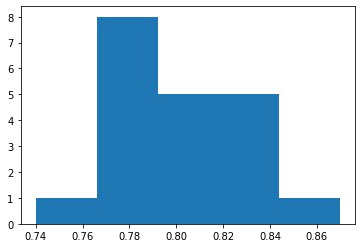

In [67]:
plt.hist(cv_scores, bins=5)

In [54]:
from sklearn.utils import resample

(array([  4.,   9.,  55.,  85.,  96., 111.,  66.,  52.,  17.,   5.]),
 array([0.7865 , 0.79005, 0.7936 , 0.79715, 0.8007 , 0.80425, 0.8078 ,
        0.81135, 0.8149 , 0.81845, 0.822  ]),
 <a list of 10 Patch objects>)

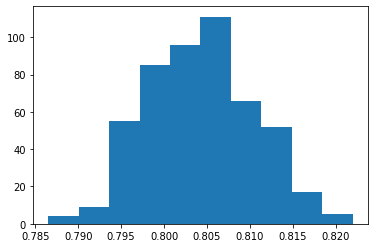

In [63]:
plt.hist([resample(cv_scores).mean() for _ in range(500)])

This can be run over and over, and every time it will give slightly different results.

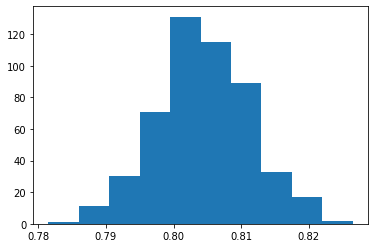

In [65]:
plt.hist([resample(cv_scores).mean() for _ in range(500)])
None   #this is the same thing, it's just the None hides the extra infomation about the array

In [69]:
ks = list(range(10, 100, 10))

In [74]:
score_results = [cross_val_score(Pipeline(steps=[('feature_transform', feature_trans),
                             ('classifier', KNeighborsClassifier(n_neighbors=k))]), features, target, cv=5)
                for k in ks]

In [76]:
score_results

[array([0.8025, 0.805 , 0.8   , 0.82  , 0.7925]),
 array([0.7875, 0.8075, 0.795 , 0.8025, 0.7875]),
 array([0.8   , 0.81  , 0.8175, 0.8025, 0.785 ]),
 array([0.8   , 0.8125, 0.82  , 0.81  , 0.785 ]),
 array([0.8025, 0.8275, 0.8175, 0.8125, 0.7875]),
 array([0.7975, 0.8225, 0.81  , 0.82  , 0.785 ]),
 array([0.8   , 0.8175, 0.8025, 0.815 , 0.785 ]),
 array([0.7975, 0.815 , 0.81  , 0.815 , 0.7775]),
 array([0.7925, 0.8175, 0.81  , 0.8125, 0.7825])]

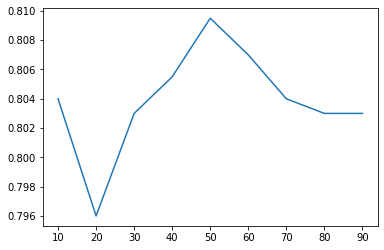

In [77]:
plt.plot(ks, [s.mean() for s in score_results])

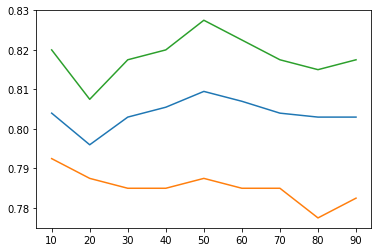

In [78]:
plt.plot(ks, [s.mean() for s in score_results])
plt.plot(ks, [s.min() for s in score_results])
plt.plot(ks, [s.max() for s in score_results])

Green:max, Blue:mean, Orange:min

In [81]:
from sklearn.model_selection import GridSearchCV

In [83]:
param_grid = {'classifier__n_neighbors':ks}   # the name of the step and the parameter
grid_search = GridSearchCV(classifier, param_grid, cv=10)

In [84]:
fit_result = grid_search.fit(features, target)

This finds the best parameters, which build your best model.

In [87]:
fit_result.best_estimator_.get_params()['steps']

[('feature_transform', ColumnTransformer(transformers=[('categorical',
                                   Pipeline(steps=[('onehot',
                                                    OneHotEncoder(drop='first'))]),
                                   ['sex', 'education', 'race']),
                                  ('continuous',
                                   Pipeline(steps=[('scale', StandardScaler())]),
                                   ['age', 'education-num'])])),
 ('classifier', KNeighborsClassifier(n_neighbors=70))]

Here we see, the alg. chose n_neighbors=70 as the best number of neighbors.

In [88]:
dummies = pd.get_dummies(features)

In [89]:
dummies

,age,fnlwgt,education-num,cap-gain,cap-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,...,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam
0,18,181712,7,0,0,12,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,51,197656,10,0,0,45,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,20,250037,10,0,0,18,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37,210945,9,0,0,24,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,27,183511,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,35,269300,13,0,0,60,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,22,267174,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
7,52,284129,10,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
8,35,148903,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,37,22463,11,0,1977,40,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [90]:
for column in dummies:
    corr = dummies[column].corr(target)
    print(f'{column}: {corr}')

age: 0.22814016735704712
fnlwgt: -0.024799150492211916
education-num: 0.3397232980285314
cap-gain: 0.2359292611074695
cap-loss: 0.13823150888236002
hours-per-week: 0.22025295827104138
workclass_ ?: -0.0914829218285114
workclass_ Federal-gov: 0.04609024105854122
workclass_ Local-gov: 0.05675236260087804
workclass_ Private: -0.07325341833027024
workclass_ Self-emp-inc: 0.09392855499315302
workclass_ Self-emp-not-inc: 0.05650833472330099
workclass_ State-gov: 0.005844073191832
education_ 10th: -0.07168458661673176
education_ 11th: -0.10344112056712088
education_ 12th: -0.05177660860998759
education_ 1st-4th: -0.03570984456152662
education_ 5th-6th: -0.03943900760308151
education_ 7th-8th: -0.05676922981994202
education_ 9th: -0.05601580434755568
education_ Assoc-acdm: 0.041953938030011635
education_ Assoc-voc: 0.011651741957930185
education_ Bachelors: 0.1406096267895298
education_ Doctorate: 0.16107487701848658
education_ HS-grad: -0.14269313160032704
education_ Masters: 0.18289761028809

Correlation will work if you have something that looks like a linear.

# Forward-stepwise 
# feature selection 

In [94]:
from sklearn.tree import DecisionTreeClassifier  

In [102]:
columns = list(features.columns)
selected_features = []
scores = []
N = 10
while len(selected_features) < N:
    best_score = pd.Series([0])
    best_feature = None
    for feature in columns:
        score = cross_val_score(DecisionTreeClassifier(max_depth=10),
                               pd.get_dummies(features[selected_features + [feature]]), target)
        if score.mean() > best_score.mean():
            best_feature = feature
            best_score = score
    print(f'{best_feature}: {best_score} ({best_score.mean()})')
    columns.remove(best_feature)
    selected_features.append(best_feature)
    scores.append(best_score)

cap-gain: [0.8225 0.835  0.7975 0.7975 0.8   ] (0.8105)
cap-loss: [0.8325 0.8375 0.815  0.8    0.81  ] (0.8190000000000002)
martial-status: [0.8325 0.845  0.82   0.805  0.8125] (0.8230000000000001)
occupation: [0.8425 0.855  0.8525 0.825  0.8475] (0.8445)
sex: [0.84   0.8475 0.855  0.825  0.85  ] (0.8434999999999999)
relationship: [0.8375 0.8475 0.8425 0.8275 0.85  ] (0.841)
workclass: [0.8375 0.855  0.8375 0.835  0.84  ] (0.841)
race: [0.8375 0.8625 0.8375 0.8275 0.81  ] (0.8350000000000002)
native-country: [0.835  0.865  0.8275 0.8225 0.81  ] (0.8320000000000001)
age: [0.835  0.8425 0.835  0.8075 0.8225] (0.8285)


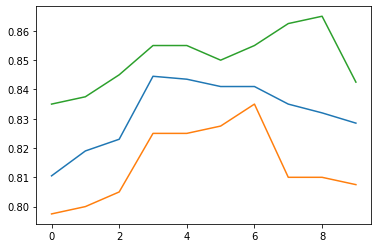

In [104]:
plt.plot([s.mean() for s in scores])
plt.plot([s.min() for s in scores])
plt.plot([s.max() for s in scores])

Let's see what results we get for a completely random data set. Hint: there should be no correlation between features!

In [105]:
import numpy

In [107]:
N = 200
random_features = pd.DataFrame(numpy.random.normal(size=(N,N)))
random_target = numpy.random.choice([0, 1], size=N)

In [109]:
from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(random_features, random_target, test_size=0.2)

In [112]:
columns = list(Xtr.columns)
selected_features = []
scores = []
N = 5
while len(selected_features) < N:
    best_score = pd.Series([0])
    best_feature = None
    for feature in columns:
        score = cross_val_score(DecisionTreeClassifier(max_depth=10),
                               pd.get_dummies(Xtr[selected_features + [feature]]), ytr)
        if score.mean() > best_score.mean():
            best_feature = feature
            best_score = score
    print(f'{best_feature}: {best_score} ({best_score.mean()})')
    columns.remove(best_feature)
    selected_features.append(best_feature)
    scores.append(best_score)

91: [0.71875 0.75    0.4375  0.71875 0.46875] (0.61875)
9: [0.6875  0.59375 0.46875 0.65625 0.65625] (0.6125)
141: [0.5625  0.6875  0.46875 0.78125 0.6875 ] (0.6375)
121: [0.65625 0.71875 0.53125 0.6875  0.6875 ] (0.65625)
108: [0.6875  0.71875 0.53125 0.78125 0.6875 ] (0.68125)


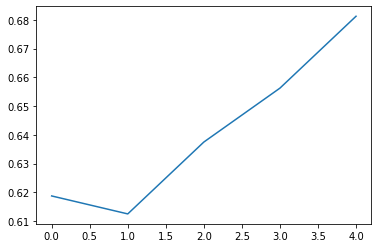

In [113]:
plt.plot([s.mean() for s in scores])

In [114]:
model = DecisionTreeClassifier(max_depth=10).fit(Xtr[selected_features], ytr)

In [115]:
from sklearn.metrics import accuracy_score

In [117]:
accuracy_score(yte, model.predict(Xte[selected_features]))

0.475

When doing feature selection:
- Use a pipeline
- Cross validate
- Use your brain to see if the features make sense

In [120]:
cv_scores_r = cross_val_score(DecisionTreeClassifier(max_depth=10), random_features[selected_features], random_target, cv=30)

In [121]:
cv_scores_r

array([0.71428571, 0.28571429, 0.28571429, 0.42857143, 0.42857143,
       0.14285714, 0.28571429, 0.71428571, 0.42857143, 0.57142857,
       0.71428571, 0.57142857, 0.71428571, 0.57142857, 0.57142857,
       0.42857143, 0.85714286, 0.71428571, 0.28571429, 0.28571429,
       0.66666667, 0.66666667, 0.5       , 0.33333333, 0.33333333,
       0.5       , 0.16666667, 1.        , 0.5       , 0.66666667])

(array([2., 5., 2., 4., 3., 4., 8., 0., 1., 1.]),
 array([0.14285714, 0.22857143, 0.31428571, 0.4       , 0.48571429,
        0.57142857, 0.65714286, 0.74285714, 0.82857143, 0.91428571,
        1.        ]),
 <a list of 10 Patch objects>)

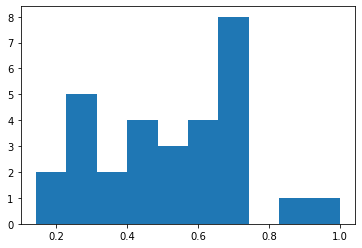

In [122]:
plt.hist(cv_scores_r)

# R-ish-Library

In [126]:
import statsmodels.formula.api as smf

In [127]:
features

,age,workclass,fnlwgt,education,education-num,martial-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country
0,18,Private,181712,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,12,United-States
1,51,Private,197656,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,20,?,250037,Some-college,10,Never-married,?,Own-child,White,Female,0,0,18,?
3,37,Private,210945,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,24,United-States
4,27,Private,183511,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
5,35,Self-emp-not-inc,269300,Bachelors,13,Never-married,Other-service,Not-in-family,Black,Female,0,0,60,United-States
6,22,Private,267174,HS-grad,9,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,40,United-States
7,52,Private,284129,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
8,35,Private,148903,HS-grad,9,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States
9,37,Private,22463,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1977,40,United-States


In [129]:
X = features.copy()

In [132]:
X['target'] = target

In [133]:
X

,age,workclass,fnlwgt,education,education-num,martial-status,occupation,relationship,race,sex,cap-gain,cap-loss,hours-per-week,native-country,target
0,18,Private,181712,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,12,United-States,0
1,51,Private,197656,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
2,20,?,250037,Some-college,10,Never-married,?,Own-child,White,Female,0,0,18,?,0
3,37,Private,210945,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,24,United-States,0
4,27,Private,183511,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0
5,35,Self-emp-not-inc,269300,Bachelors,13,Never-married,Other-service,Not-in-family,Black,Female,0,0,60,United-States,0
6,22,Private,267174,HS-grad,9,Never-married,Handlers-cleaners,Own-child,Black,Male,0,0,40,United-States,0
7,52,Private,284129,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,1
8,35,Private,148903,HS-grad,9,Divorced,Sales,Unmarried,White,Female,0,0,40,United-States,0
9,37,Private,22463,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1977,40,United-States,1


In [138]:
sm_fit = smf.logit("target ~ age + Q('education-num') + sex + race", data=X).fit()  #logistic regression


Optimization terminated successfully.
         Current function value: 0.436169
         Iterations 7


In [139]:
sm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1992
Method:                           MLE   Df Model:                            7
Date:                Fri, 04 Sep 2020   Pseudo R-squ.:                  0.2102
Time:                        16:31:32   Log-Likelihood:                -872.34
converged:                       True   LL-Null:                       -1104.5
Covariance Type:            nonrobust   LLR p-value:                 3.873e-96
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -7.5958      0.782     -9.710      0.000      -9.129      -6.063
sex[T. Male]                    1.4136      0.150      9.412      0.000       1.119       1.708
race[T. Asian-Pac-Islander]     0.0090      0.754      0.012      0.990      -1.468       1.486
race[T. Black]                 -0.5895      0.735     -0.803      0.422      -2.029       0.850
race[T. Other]                 -0.7432      1.048     -0.709      0.478      -2.797       1.311
race[T. White]                 -0.1541      0.694     -0.222      0.824      -1.513       1.205
age                             0.0406      0.005      8.879      0.000       0.032       0.050
Q('education-num')              0.3711      0.027     13.873      0.000       0.319       0.424
===============================================================================================
"""